<font size="15">Volatility surface and Options Strategy_SPX</font>


In [8]:
import yfinance as yf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import plotly.graph_objects as go

In [9]:
# Fetch multiple expiries for SPX
ticker = yf.Ticker("^SPX")
expiries = ticker.options[:5]  # First 5 expiries

strikes_all, days_all, iv_all = [], [], []

for expiry in expiries:
    try:
        chain = ticker.option_chain(expiry)
        calls = chain.calls.dropna()
        strike = calls['strike'].values
        iv = calls['impliedVolatility'].values
        days_to_expiry = (pd.to_datetime(expiry) - pd.Timestamp.today()).days
        days = [days_to_expiry] * len(strike)
        strikes_all.extend(strike)
        days_all.extend(days)
        iv_all.extend(iv)
    except:
        continue

# Create DataFrame and export
df_iv = pd.DataFrame({
    'Strike': strikes_all,
    'Days_to_Expiry': days_all,
    'ImpliedVol': iv_all
})
df_iv.to_csv("spx_vol_surface_calls.csv", index=False)
print("Saved: spx_vol_surface_calls.csv")

Saved: spx_vol_surface_calls.csv


Understanding the Volatility Smile Progression, this section introduces how we visualize implied volatility (IV) against strike prices, commonly known as the volatility smile.

#1: SPX Option Volatility Smile (Single Expiry)
We start with the IV vs. strike for the nearest expiry. This helps identify the skew pattern at a single point in time.

#2: Implied Volatility Smile Across Expiries
We then expand the idea by plotting smiles for multiple expiries to observe how the skew evolves (i.e., the term structure of skew).

#3: Implied Volatility Smile (Normalized by Moneyness)
Since each expiry has different strike ranges, raw smiles become messy. We normalize each strike by the current SPX spot price (i.e., moneyness = strike / spot) so all curves align around ATM (moneyness = 1). This allows for a clean, meaningful comparison.

Together, these three plots build progressively from a simple skew view to a clear, comparative skew+term structure visual.

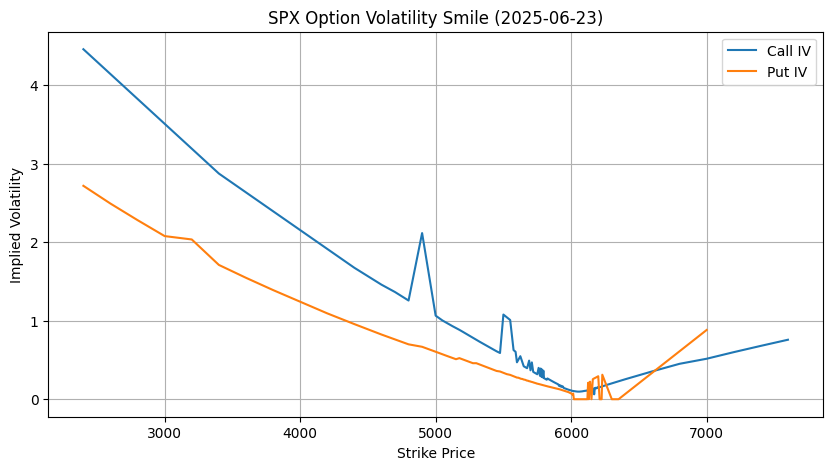

In [10]:
#1: SPX Option Volatility Smile (Single Expiry)

# Fetch SPX options chain
ticker = yf.Ticker("^SPX")
expiry = ticker.options[0]  # Nearest expiry
chain = ticker.option_chain(expiry)

calls = chain.calls
puts = chain.puts

# Plot Implied Volatility vs Strike
plt.figure(figsize=(10,5))
plt.plot(calls['strike'], calls['impliedVolatility'], label='Call IV')
plt.plot(puts['strike'], puts['impliedVolatility'], label='Put IV')
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.title(f'SPX Option Volatility Smile ({expiry})')
plt.legend()
plt.grid(True)
plt.show()

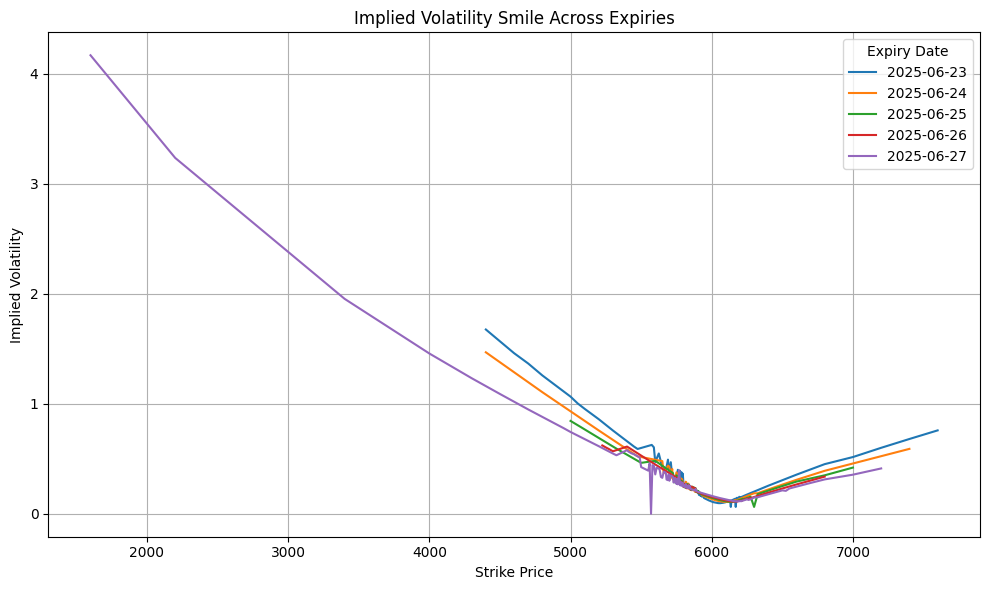

In [11]:
#2: Implied Volatility Smile Across Expiries

plt.figure(figsize=(10, 6))

for expiry in expiries[:5]:  # Limit to first 5 for clarity
    try:
        chain = ticker.option_chain(expiry)
        calls = chain.calls.dropna()
        plt.plot(calls['strike'], calls['impliedVolatility'], label=expiry)
    except:
        continue

plt.title("Implied Volatility Smile Across Expiries")
plt.xlabel("Strike Price")
plt.ylabel("Implied Volatility")
plt.legend(title="Expiry Date")
plt.grid(True)
plt.tight_layout()
plt.show()


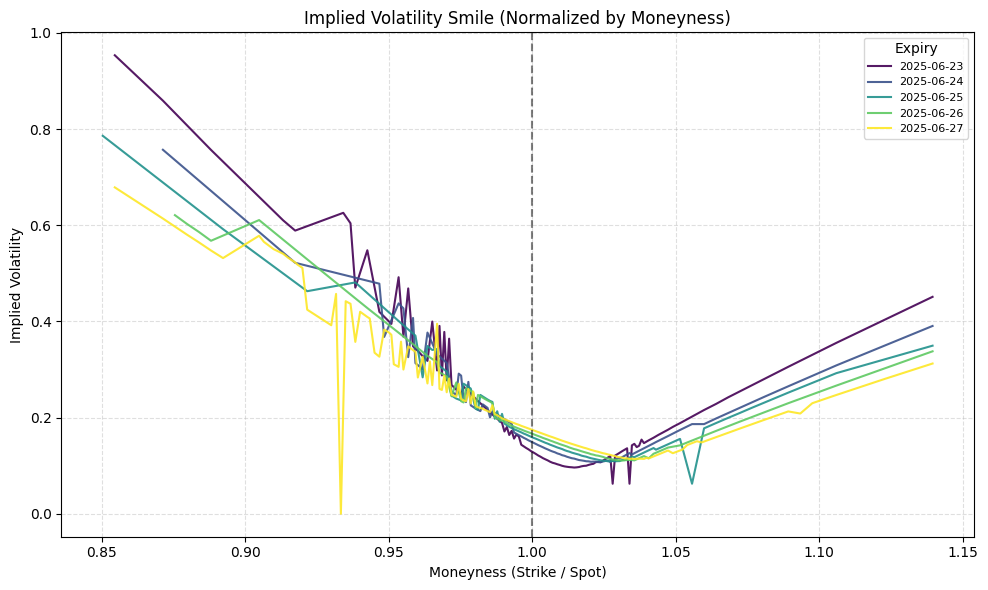

In [12]:
#3: Implied Volatility Smile (Normalized by Moneyness)

ticker = yf.Ticker("^SPX")
spot_price = ticker.history(period="1d")['Close'].iloc[-1]
expiries = ticker.options[:5]

plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(expiries)))

for i, expiry in enumerate(expiries):
    try:
        chain = ticker.option_chain(expiry)
        calls = chain.calls.dropna()
        calls = calls[(calls['impliedVolatility'] > 0) & (calls['impliedVolatility'] < 1)]  # Clean outliers
        calls['moneyness'] = calls['strike'] / spot_price

        data = calls[(calls['moneyness'] > 0.85) & (calls['moneyness'] < 1.15)]

        if len(data) > 5:
            plt.plot(data['moneyness'], data['impliedVolatility'],
                     label=expiry, color=colors[i], alpha=0.9, linewidth=1.5)
    except Exception as e:
        continue

plt.title("Implied Volatility Smile (Normalized by Moneyness)")
plt.xlabel("Moneyness (Strike / Spot)")
plt.ylabel("Implied Volatility")
plt.axvline(1, linestyle='--', color='black', alpha=0.5)
plt.legend(title="Expiry", fontsize=8)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

In [13]:
# Interactive 3D Plot using Plotly for "SPX Implied Volatility Surface"
fig = go.Figure(data=[go.Mesh3d(
    x=strikes_all,
    y=days_all,
    z=iv_all,
    opacity=0.9,
    colorscale='Viridis',
    intensity=iv_all,
    showscale=True
)])
fig.update_layout(
    scene=dict(
        xaxis_title='Strike',
        yaxis_title='Days to Expiry',
        zaxis_title='Implied Volatility',
        camera=dict(eye=dict(x=1.5, y=1.5, z=0.8))
    ),
    title='SPX Implied Volatility Surface (Interactive)',
    margin=dict(l=0, r=0, b=0, t=40)
)
fig.show()

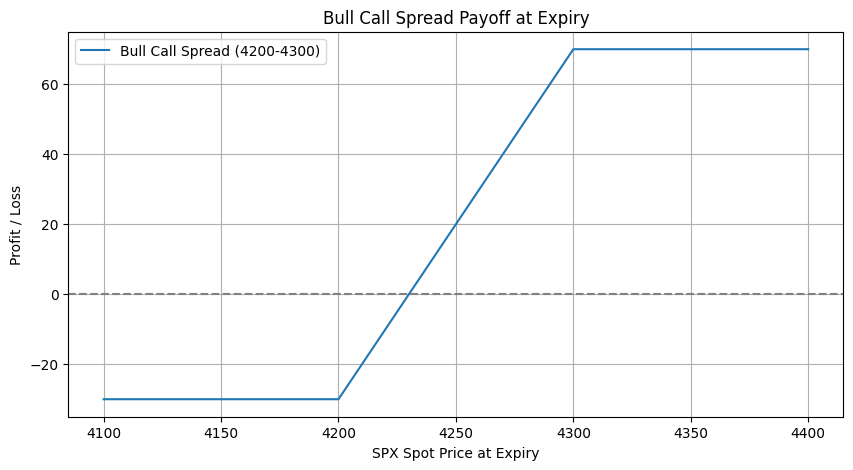

In [14]:
# Bull Call Spread Simulation
def bull_call_spread_payoff(S, K1, K2, premium1, premium2):
    return np.maximum(S - K1, 0) - premium1 - (np.maximum(S - K2, 0) - premium2)

K1, K2 = 4200, 4300
S_range = np.linspace(4100, 4400, 100)
premium1, premium2 = 50, 20

spread_pnl = bull_call_spread_payoff(S_range, K1, K2, premium1, premium2)

plt.figure(figsize=(10, 5))
plt.plot(S_range, spread_pnl, label=f'Bull Call Spread ({K1}-{K2})')
plt.axhline(0, linestyle='--', color='gray')
plt.title("Bull Call Spread Payoff at Expiry")
plt.xlabel("SPX Spot Price at Expiry")
plt.ylabel("Profit / Loss")
plt.grid(True)
plt.legend()
plt.show()